In [1]:
# 1 Environments
# In this programming task, you’ll utilize the following Gymnasium environments for training
# and evaluating your policies:
# • Acrobot-v1: The system consists of two links connected linearly to form a chain, with
# one end of the chain fixed. The joint between the two links is actuated. The goal is to
# apply torques on the actuated joint to swing the free end of the linear chain above a
# given height while starting from the initial state of hanging downwards.
# • CartPole-v1: A pole is attached by an un-actuated joint to a cart, which moves along
# a frictionless track. The pendulum is placed upright on the cart and the goal is to
# balance the pole by applying forces in the left and right direction on the cart.

# 2 Algorithms
# You are tasked with training two variants of each Dueling-DQN and Monte-Carlo REINFORCE and assessing their comparative performance.

# 2.1 Dueling-DQN
# Dueling DQN is an extension of the DQN algorithm, designed to improve learning efficiency
# by decomposing the Q-value function into two separate streams: one estimating the state
# value and the other estimating the advantage of each action. The update equation for the
# dueling network is:
# Q(s, a; θ) = V (s; θ) + (A(s, a; θ) − 1/|A| sum_a′∈|A| A(s, a′; θ)) -> (Type-1)
# Where Q(s, a; θ) represents the dueling Q-function with parameters θ.
# Following is another way to estimate the Q-values:
# Q(s, a; θ) = V (s; θ) +  A(s, a; θ) − max_{a′∈|A|} A(s, a′; θ) -> (Type-2)

# Implement both update rules (Type-1) & (Type-2) and compare their performance in both the environments.



# 2.2 Monte-Carlo REINFORCE
# The MC-REINFORCE (Chapter 13) algorithm utilizes Monte Carlo sampling to estimate
# gradients for policy optimization. The update equation of its policy parameter θ is given by
# θ = θ + αGt ∇π(At |St , θ) / π(At |St , θ) -> (w/o Baseline)
# In the presence of baseline, V (·; Φ) , the update equation is given by
# θ = θ + α(Gt − V (St ; Φ)) ∇π(At |St , θ) / π(At |St , θ) -> (w/ Baseline)

# The baseline V (·; Φ) is updated by TD(0) method.
# Implement MC REINFORCE with both update methods ((w/o Baseline) &
# (w/ Baseline)) and compare their performance in both the environments.

# 3 Instructions
# Four results plots (2 environments × 2 algorithms) (Ex. Plot 1 should compare (Type-1)
# & (Type-2) Dueling DQN in Acrobot environment)
# Use γ = 0.99 for all experiments
# • Tune the hyper-parameter to minimize the regret in all experiments
# • To account for stochasticity, use the average of 5 random seeds for each experiment/plot
# • Plot the episodic return versus episodic number for every experiment
# • The plots should consist the mean and variance across the 5 runs/seeds



In [2]:
# Importing required libraries
import os
import gym
import csv
# from gym.wrappers import Monitor
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as nn_utils
import math
import random
import copy
import time
import imageio
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
def seed_all(seed=None):
    if seed is None:
        seed = 87 + 122

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_all()

## Parameters

In [4]:
class Args:
    def __init__(self):
        self.h1_dim = 128
        self.h2_dim = 128
        self.gamma = 0.99 # Discount factor (constant)

        self.lr = 1e-4 # Learning rate for policy network
        self.batch_size = 32 # Batch size for experience replay
        self.buffer_size = int(1e4) # Experience replay buffer size
        self.target_update_freq = 20 # Frequency of updating target network

        self.lr_theta = 1e-4 # Learning rate for policy network
        self.lr_w = 1e-4 # Learning rate for value network

        self.max_episodes = 1000
        self.max_steps = 500
        self.runs = 5
        self.epsilon0 = 1.0
        # self.min_epsilon = 0.001
        # self.epsilon_decay = 0.99
        self.min_epsilon = 0.0001
        self.epsilon_decay = 0.98
        self.print_freq = 200

args = Args()


In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_all()

## Dueling DQN

In [6]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

In [7]:
# Dueling DQN
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim, update_type=1, args=args):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)

        self.value = nn.Linear(args.h2_dim, 1)
        self.advantage = nn.Linear(args.h2_dim, action_dim)
        self.update_type = update_type
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        value = self.value(x)
        advantage = self.advantage(x)

        if self.update_type == 1:
            q = value + (advantage - advantage.mean(dim=-1, keepdim=True))
        elif self.update_type == 2:
            q = value + (advantage - advantage.max(dim=-1, keepdim=True)[0])
        else:
            raise NotImplementedError("Update type not implemented")

        return q


In [8]:
# Dueling DQN Agent
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, update_type=1, args=args):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.update_type = update_type
        self.args = args
        self.q_net = DuelingDQN(state_dim, action_dim, update_type, self.args).to(device)
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.args.lr)
        self.loss_fn = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(self.args.buffer_size)
        self.steps = 0

    def act(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_net(state)
        return q_values.argmax().item()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.args.batch_size:
            return 0

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.args.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_net(states)
        next_q_values = self.target_net(next_states).detach()

        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(dim=-1)[0]
        target = rewards + self.args.gamma * next_q_value * (1 - dones)

        loss = self.loss_fn(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.steps += 1
        if self.steps % self.args.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        return loss.item()

    def save(self, path):
        torch.save(self.q_net.state_dict(), path)

    def load(self, path):
        self.q_net.load_state_dict(torch.load(path))
        self.target_net = copy.deepcopy(self.q_net)
        self.target_net.eval()



## Monte-Carlo REINFORCE

In [9]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, args=args):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)
        self.fc3 = nn.Linear(args.h2_dim, action_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)


In [10]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, args=args):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, args.h1_dim)
        self.fc2 = nn.Linear(args.h1_dim, args.h2_dim)
        self.fc3 = nn.Linear(args.h2_dim, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu', mode='fan_in')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [11]:
class MonteCarloREINFORCEAgent:
    def __init__(self, state_dim, action_dim, baseline=False, args=args):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.args = args
        self.policy_net = PolicyNetwork(state_dim, action_dim, self.args).to(device)
        self.value_net = ValueNetwork(state_dim, self.args).to(device)
        self.optimizer_theta = optim.Adam(self.policy_net.parameters(), lr=self.args.lr_theta)
        self.optimizer_w = optim.Adam(self.value_net.parameters(), lr=self.args.lr_w)
        self.baseline = baseline
        self.loss_fn = nn.MSELoss()
        self.steps = 0

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.policy_net(state)
        action = torch.distributions.Categorical(probs).sample()
        return action.item()

    def update(self, trajectory):
        states, actions, rewards = zip(*trajectory)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)

        returns = self._compute_returns(rewards)
        # returns = (returns - returns.mean()) / (returns.std() + 1e-8) if self.baseline else returns

        if self.baseline:
            values = self.value_net(states).squeeze()
            loss_w = self.loss_fn(values, returns)
            self.optimizer_w.zero_grad()
            loss_w.backward()
            self.optimizer_w.step()

        log_probs = torch.log(self.policy_net(states))
        log_probs_actions = log_probs[range(len(actions)), actions]
        loss_theta = -torch.sum(log_probs_actions * returns)

        self.optimizer_theta.zero_grad()
        loss_theta.backward()
        self.optimizer_theta.step()

        self.steps += 1
        return loss_theta.item()

    def _compute_returns(self, rewards):
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.args.gamma * G
            returns.insert(0, G)
        return torch.FloatTensor(returns).to(device)



## Trainer

In [12]:
# Training for Dueling DQN and REINFORCE
class Trainer:
    def __init__(self, env_name, agent_type, update_type=None, baseline=False, args=args, save_results=True):
        self.env_name = env_name
        self.agent_type = agent_type
        self.update_type = update_type
        self.baseline = baseline
        self.env = gym.make(env_name)
        # self.env = gym.make(env_name, render_mode='human')
        # self.env = Monitor(self.env, f'{env_name}_{agent_type}_{update_type}', force=True)
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.args = args
        self.save_results = save_results

    def get_agent(self):
        if self.agent_type == "dueling_dqn":
            return DuelingDQNAgent(self.state_dim, self.action_dim, self.update_type, self.args)
        elif self.agent_type == "reinforce":
            return MonteCarloREINFORCEAgent(self.state_dim, self.action_dim, self.baseline, self.args)
        else:
            raise NotImplementedError("Agent not implemented")

    def train(self):
        rewards = np.zeros((self.args.runs, self.args.max_episodes))
        losses = np.zeros((self.args.runs, self.args.max_episodes))
        returns = np.zeros((self.args.runs, self.args.max_episodes))
        for run in tqdm(range(self.args.runs)):
            seed_all(seed=run)
            self.agent = self.get_agent()
            rewards[run], losses[run], returns[run] = self.train_single_run()
            clear_output(wait=True)
        # self.rewards_mean = rewards.mean(axis=0)
        self.rewards = rewards
        self.losses = losses
        self.returns = returns
        if self.save_results:
            self.save() # Save the results
        return rewards, losses, returns

    def train_single_run(self):
        if self.agent_type == "dueling_dqn":
            return self.train_DuelingDQN()
        elif self.agent_type == "reinforce":
            return self.train_MC_REINFORCE()
        else:
            raise NotImplementedError("Agent not implemented")

    def train_DuelingDQN(self):
        rewards = []
        losses = []
        episodic_returns = []
        # frames = []
        for episode in range(self.args.max_episodes):
            state = self.env.reset()
            episode_reward = 0
            episodic_return = 0
            for step in range(self.args.max_steps):
                epsilon = max(self.args.min_epsilon, self.args.epsilon0 * self.args.epsilon_decay**self.agent.steps)
                action = self.agent.act(state, epsilon)
                next_state, reward, done, _ = self.env.step(action)
                loss = self.agent.update(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                episodic_return = self.args.gamma * episodic_return + reward
                # frames.append(self.env.render())
                if done:
                    break
            rewards.append(episode_reward)
            losses.append(loss)
            episodic_returns.append(episodic_return)
            if episode % self.args.print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        self.env.close()
        # self.save_simulation(frames, f"{self.env_name}_{self.agent_type}_{self.update_type}.mp4")
        return rewards, losses, episodic_returns

    def train_MC_REINFORCE(self):
        rewards = []
        losses = []
        episodic_returns = []
        for episode in range(self.args.max_episodes):
            state = self.env.reset()
            episode_reward = 0
            episodic_return = 0
            trajectory = []
            for step in range(self.args.max_steps):
                action = self.agent.act(state)
                next_state, reward, done, _ = self.env.step(action)
                trajectory.append((state, action, reward))
                state = next_state
                episode_reward += reward
                episodic_return = self.args.gamma * episodic_return + reward
                if done:
                    break
            rewards.append(episode_reward)
            loss = self.agent.update(trajectory)
            losses.append(loss)
            episodic_returns.append(episodic_return)
            if episode % self.args.print_freq == 0:
                print("Episode: {}, Reward: {}".format(episode, episode_reward))
        return rewards, losses, episodic_returns

    def save(self):
        if self.agent_type == "dueling_dqn":
            os.makedirs("results", exist_ok=True)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_rewards.npy", self.rewards)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_losses.npy", self.losses)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.update_type}_returns.npy", self.returns)
        elif self.agent_type == "reinforce":
            os.makedirs("results", exist_ok=True)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_rewards.npy", self.rewards)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_losses.npy", self.losses)
            np.save(f"results/{self.env_name}_{self.agent_type}_{self.baseline}_returns.npy", self.returns)
        else:
            raise NotImplementedError("Agent not implemented")

    @staticmethod
    def save_simulation(frames, filename):
        imageio.mimsave(filename, frames, fps=30)

    # def save(self, path):
    #     self.agent.save(path)

    # def load(self, path):
    #     self.agent.load(path)

In [13]:
def results_loader(env_name, agent_type, update_type=None, baseline=False):
    if agent_type == "dueling_dqn":
        rewards = np.load(f"results/{env_name}_{agent_type}_{update_type}_rewards.npy")
        losses = np.load(f"results/{env_name}_{agent_type}_{update_type}_losses.npy")
        returns = np.load(f"results/{env_name}_{agent_type}_{update_type}_returns.npy")
    elif agent_type == "reinforce":
        rewards = np.load(f"results/{env_name}_{agent_type}_{baseline}_rewards.npy")
        losses = np.load(f"results/{env_name}_{agent_type}_{baseline}_losses.npy")
        returns = np.load(f"results/{env_name}_{agent_type}_{baseline}_returns.npy")
    else:
        raise NotImplementedError("Agent not implemented")
    return rewards, losses, returns

In [14]:
def plot_rewards(rewards1, rewards2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards1.mean(axis=0), label="Type-1")
    plt.fill_between(np.arange(rewards1.shape[1]), rewards1.mean(axis=0) - rewards1.std(axis=0), rewards1.mean(axis=0) + rewards1.std(axis=0), alpha=0.3)
    plt.plot(rewards2.mean(axis=0), label="Type-2")
    plt.fill_between(np.arange(rewards2.shape[1]), rewards2.mean(axis=0) - rewards2.std(axis=0), rewards2.mean(axis=0) + rewards2.std(axis=0), alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Episodic Rewards")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_losses(losses1, losses2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(losses1.mean(axis=0), label="Type-1")
    plt.fill_between(np.arange(losses1.shape[1]), losses1.mean(axis=0) - losses1.std(axis=0), losses1.mean(axis=0) + losses1.std(axis=0), alpha=0.3)
    plt.plot(losses2.mean(axis=0), label="Type-2")
    plt.fill_between(np.arange(losses2.shape[1]), losses2.mean(axis=0) - losses2.std(axis=0), losses2.mean(axis=0) + losses2.std(axis=0), alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_returns(returns1, returns2, title, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(returns1.mean(axis=0), label="Type-1")
    plt.fill_between(np.arange(returns1.shape[1]), returns1.mean(axis=0) - returns1.std(axis=0), returns1.mean(axis=0) + returns1.std(axis=0), alpha=0.3)
    plt.plot(returns2.mean(axis=0), label="Type-2")
    plt.fill_between(np.arange(returns2.shape[1]), returns2.mean(axis=0) - returns2.std(axis=0), returns2.mean(axis=0) + returns2.std(axis=0), alpha=0.3)
    plt.xlabel("Episodes")
    plt.ylabel("Episodic Returns")
    plt.title(title)
    plt.legend()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Hyperparameter Tuning

In [15]:
def dueling_dqn_acrobot_hyperparameter_tuning():
    # Ensure the directory exists or create it if it doesn't
    os.makedirs("hptuning/", exist_ok=True)

    tuned_args = Args()
    batch_sizes = [32, 128, 1024]
    buffer_sizes = [int(1e4), int(1e3)]
    target_update_freqs = [20, 50]

    best_hyperparameters = None
    best_mean = -np.inf

    # Define the filename for the CSV file
    filename = 'hptuning/dueling_dqn_acrobot.csv'

    # Write the data to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Batch Size', 'Buffer Size', 'Target Update Freq', 'Average Rewards Mean'])

        for batch_size in batch_sizes:
            for buffer_size in buffer_sizes:
                for target_update_freq in target_update_freqs:
                    tuned_args.batch_size = batch_size
                    tuned_args.buffer_size = buffer_size
                    tuned_args.target_update_freq = target_update_freq
                    trainer = Trainer("Acrobot-v1", "dueling_dqn", update_type=1, args=tuned_args, save_results=False)
                    rewards, _, _ = trainer.train()
                    rewards_mean = rewards.mean(axis=0) # mean of rewards over 5 runs
                    avg_rewards_mean = np.mean(rewards_mean) # mean of all episodes

                    csvwriter.writerow([batch_size, buffer_size, target_update_freq, avg_rewards_mean])

                    if avg_rewards_mean > best_mean:
                        best_mean = avg_rewards_mean
                        best_hyperparameters = (batch_size, buffer_size, target_update_freq)

    tuned_args.batch_size, tuned_args.buffer_size, tuned_args.target_update_freq = best_hyperparameters
    return tuned_args


In [16]:
def dueling_dqn_cartpole_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    os.makedirs("hptuning/", exist_ok=True)
    tuned_args = Args()
    batch_sizes = [32, 128, 1024]
    buffer_sizes = [int(1e4), int(1e3)]
    target_update_freqs = [20, 50]

    best_hyperparameters = None
    best_mean = -np.inf

    filename = 'hptuning/dueling_dqn_cartpole.csv'

    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Batch Size', 'Buffer Size', 'Target Update Freq', 'Average Rewards Mean'])

        for batch_size in batch_sizes:
            for buffer_size in buffer_sizes:
                for target_update_freq in target_update_freqs:
                    tuned_args.batch_size = batch_size
                    tuned_args.buffer_size = buffer_size
                    tuned_args.target_update_freq = target_update_freq
                    trainer = Trainer("CartPole-v1", "dueling_dqn", update_type=1, args=tuned_args, save_results=False)
                    rewards, _, _ = trainer.train()
                    rewards_mean = rewards.mean(axis=0) # mean of rewards over 5 runs
                    avg_rewards_mean = np.mean(rewards_mean) # mean of all episodes

                    csvwriter.writerow([batch_size, buffer_size, target_update_freq, avg_rewards_mean])

                    if avg_rewards_mean > best_mean:
                        best_mean = avg_rewards_mean
                        best_hyperparameters = (batch_size, buffer_size, target_update_freq)


    tuned_args.batch_size, tuned_args.buffer_size, tuned_args.target_update_freq = best_hyperparameters
    return tuned_args

In [17]:
def mc_reinforce_acrobot_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    os.makedirs("hptuning/", exist_ok=True)
    tuned_args = Args()
    h1_dims = [128, 256]
    h2_dims = [64, 128]

    best_hyperparameters = None
    best_mean = -np.inf

    # Define the filename for the CSV file
    filename = 'hptuning/mc_reinforce_acrobot.csv'

    # Write the data to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Batch Size', 'Buffer Size', 'Target Update Freq', 'Average Rewards Mean'])

        for h1_dim in h1_dims:
            for h2_dim in h2_dims:
                tuned_args.h1_dim = h1_dim
                tuned_args.h2_dim = h2_dim
                trainer = Trainer("Acrobot-v1", "reinforce", baseline=False, args=tuned_args, save_results=False)
                rewards, _, _ = trainer.train()
                rewards_mean = rewards.mean(axis=0)
                avg_rewards_mean = np.mean(rewards_mean)

                csvwriter.writerow([h1_dim, h2_dim, avg_rewards_mean])

                if avg_rewards_mean > best_mean:
                    best_mean = avg_rewards_mean
                    best_hyperparameters = (h1_dim, h2_dim)

    tuned_args.h1_dim, tuned_args.h2_dim = best_hyperparameters
    return tuned_args


In [18]:
def mc_reinforce_cartpole_hyperparameter_tuning():
    # may tune on 100 episodes rather than 1000
    os.makedirs("hptuning/", exist_ok=True)
    tuned_args = Args()
    h1_dims = [128, 256]
    h2_dims = [64, 128]

    best_hyperparameters = None
    best_mean = -np.inf

    # Define the filename for the CSV file
    filename = 'hptuning/mc_reinforce_cartpole.csv'

    # Write the data to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Batch Size', 'Buffer Size', 'Target Update Freq', 'Average Rewards Mean'])

        for h1_dim in h1_dims:
            for h2_dim in h2_dims:
                tuned_args.h1_dim = h1_dim
                tuned_args.h2_dim = h2_dim
                trainer = Trainer("CartPole-v1", "reinforce", baseline=False, args=tuned_args, save_results=False)
                rewards, _, _ = trainer.train()
                rewards_mean = rewards.mean(axis=0)
                avg_rewards_mean = np.mean(rewards_mean)

                csvwriter.writerow([h1_dim, h2_dim, avg_rewards_mean])

                if avg_rewards_mean > best_mean:
                    best_mean = avg_rewards_mean
                    best_hyperparameters = (h1_dim, h2_dim)

    tuned_args.h1_dim, tuned_args.h2_dim = best_hyperparameters
    return tuned_args

## Experiments

### Dueling DQN

In [19]:
# # Hyperparameter tuning
# args = Args()
# # args_ddqn_acrobot = dueling_dqn_acrobot_hyperparameter_tuning()
# # print("Tuned Hyperparameters Dueling DQN Acrobot: ", args_ddqn_acrobot.__dict__)
# # args = args_ddqn_acrobot

# # After tuning, the best hyperparameters for Dueling DQN Acrobot are:
# # 1024	10000	20	-83.446
# args.batch_size = 1024
# args.buffer_size = int(1e4)
# args.target_update_freq = 20


In [20]:
# # Dueling DQN
# # Acrobot-v1 using Type-1 update
# env_name = "Acrobot-v1"
# agent_type = "dueling_dqn"
# trainer = Trainer(env_name, agent_type, update_type=1, args=args)
# rewards1, losses1, returns1 = trainer.train()

# # Acrobot-v1 using Type-2 update
# env_name = "Acrobot-v1"
# agent_type = "dueling_dqn"
# trainer = Trainer(env_name, agent_type, update_type=2, args=args)
# rewards2, losses2, returns2 = trainer.train()

# # Load results
# rewards1, losses1, returns1 = results_loader("Acrobot-v1", "dueling_dqn", update_type=1)
# rewards2, losses2, returns2 = results_loader("Acrobot-v1", "dueling_dqn", update_type=2)

# # Plots
# plot_rewards(rewards1, rewards2, "Dueling DQN Acrobot-v1", "plots/dueling_dqn_acrobot_rewards")
# plot_losses(losses1, losses2, "Dueling DQN Acrobot-v1", "plots/dueling_dqn_acrobot_losses")
# plot_returns(returns1, returns2, "Dueling DQN Acrobot-v1", "plots/dueling_dqn_acrobot_returns")


In [21]:
# Hyperparameter tuning
args = Args()
# args_ddqn_cartpole = dueling_dqn_cartpole_hyperparameter_tuning()
# print("Tuned Hyperparameters Dueling DQN CartPole: ", args_ddqn_cartpole.__dict__)
# args = args_ddqn_cartpole

# 'batch_size': 128, 'buffer_size': 10000, 'target_update_freq': 20,
args.batch_size = 128
args.buffer_size = 10000
args.target_update_freq = 20

100%|██████████████████████████████████████████| 5/5 [1:02:27<00:00, 749.51s/it]


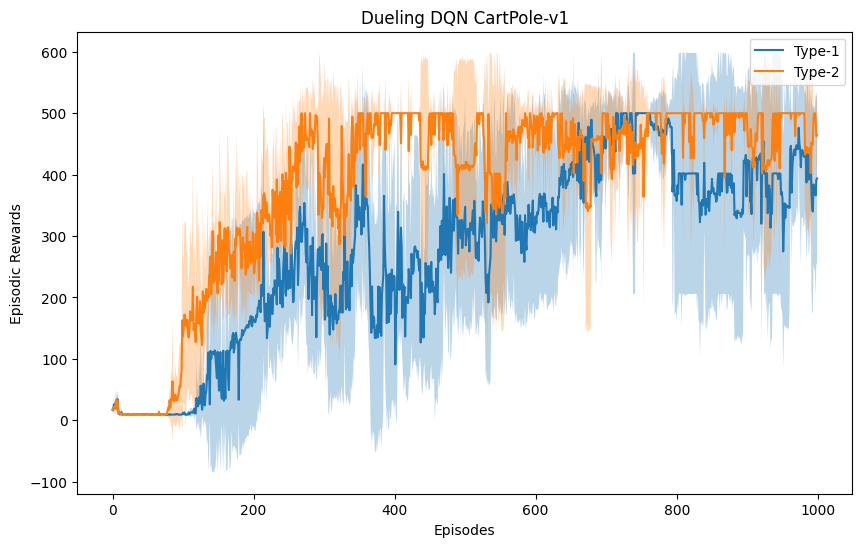

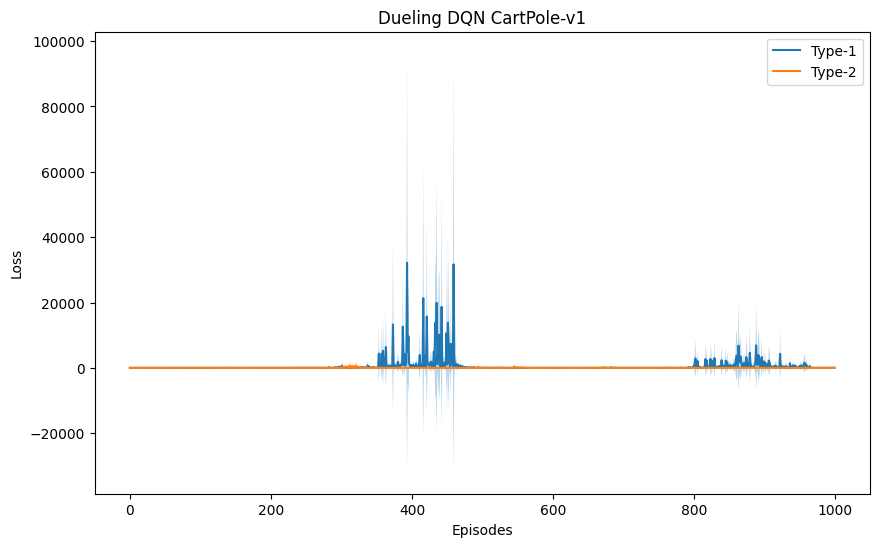

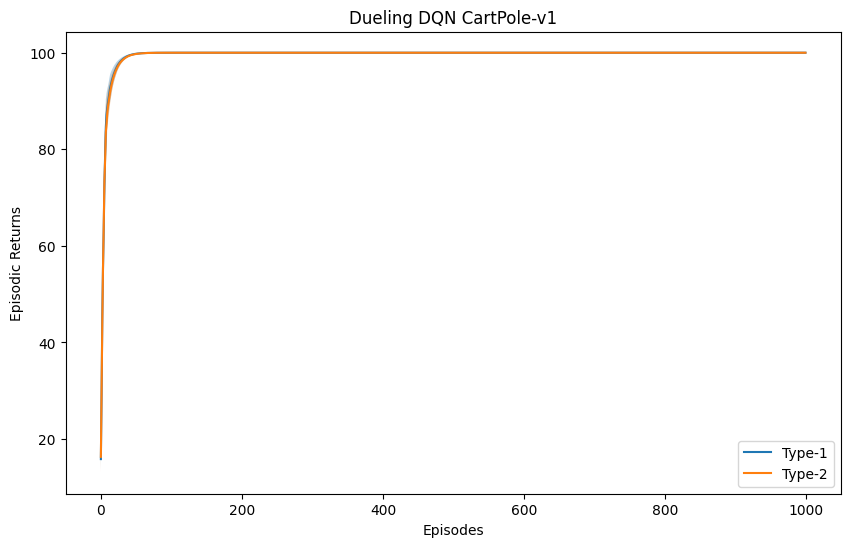

In [22]:
# Dueling DQN
# CartPole-v1 using Type-1 update
env_name = "CartPole-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=1, args=args)
rewards1, losses1, returns1 = trainer.train()

# CartPole-v1 using Type-2 update
env_name = "CartPole-v1"
agent_type = "dueling_dqn"
trainer = Trainer(env_name, agent_type, update_type=2, args=args)
rewards2, losses2, returns2 = trainer.train()

# Load results
rewards1, losses1, returns1 = results_loader("CartPole-v1", "dueling_dqn", update_type=1)
rewards2, losses2, returns2 = results_loader("CartPole-v1", "dueling_dqn", update_type=2)

# Plots
plot_rewards(rewards1, rewards2, "Dueling DQN CartPole-v1", "plots/dueling_dqn_cartpole_rewards")
plot_losses(losses1, losses2, "Dueling DQN CartPole-v1", "plots/dueling_dqn_cartpole_losses")
plot_returns(returns1, returns2, "Dueling DQN CartPole-v1", "plots/dueling_dqn_cartpole_returns")

### Monte-Carlo REINFORCE

In [23]:
# Hyperparameter tuning
args = Args()
# args_mc_reinforce_acrobot = mc_reinforce_acrobot_hyperparameter_tuning()
# print("Tuned Hyperparameters MC REINFORCE Acrobot: ", args_mc_reinforce_acrobot.__dict__)
# args = args_mc_reinforce_acrobot
args.h1_dim = 128
args.h2_dim = 64

100%|████████████████████████████████████████████| 5/5 [09:55<00:00, 119.18s/it]


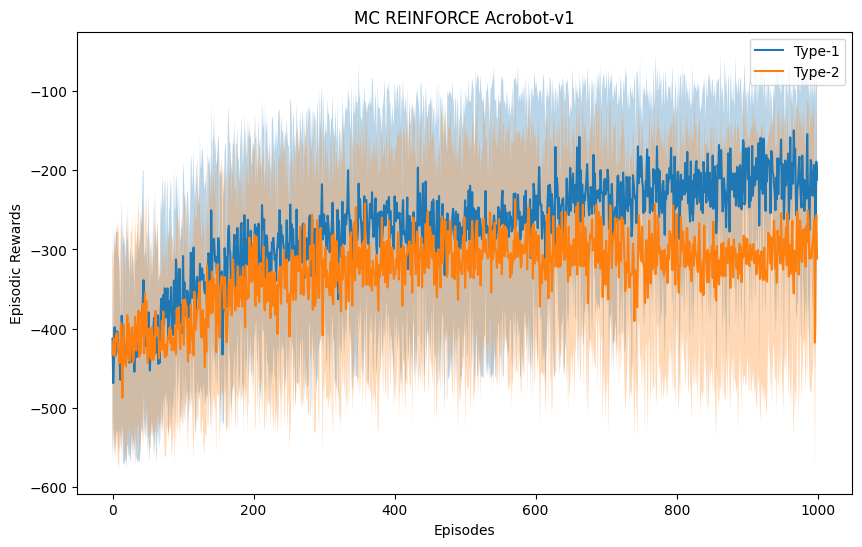

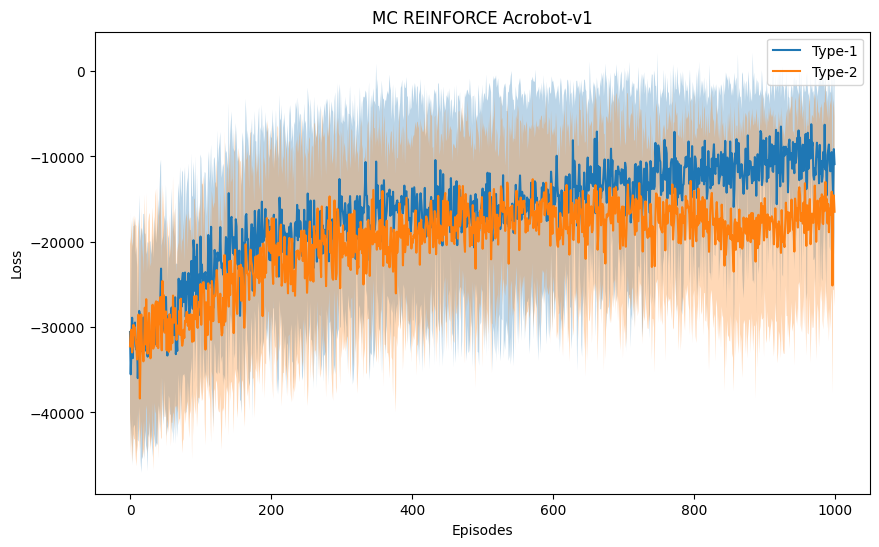

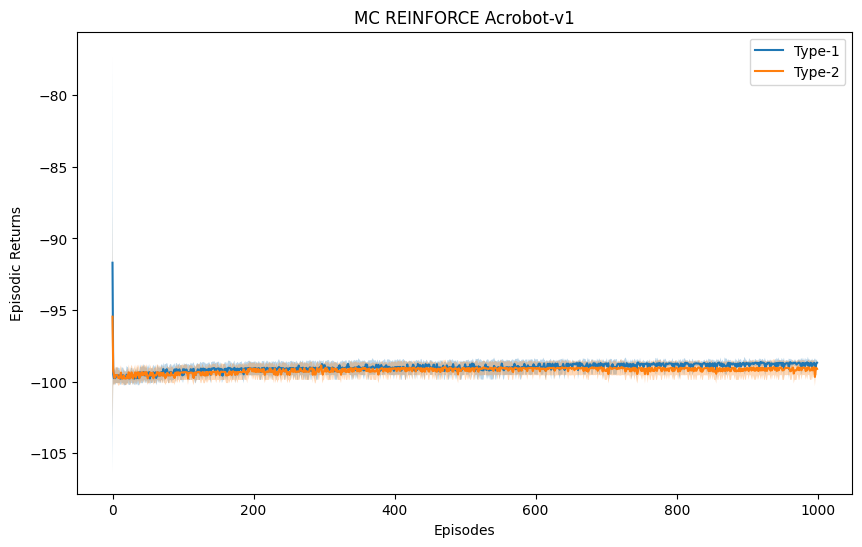

In [24]:
# Monte Carlo REINFORCE
# Acrobot-v1 without baseline
env_name = "Acrobot-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False, args=args)
rewards1, losses1, returns1 = trainer.train()

# Acrobot-v1 with baseline
env_name = "Acrobot-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True, args=args)
rewards1, losses1, returns1 = trainer.train()

# Load results
rewards1, losses1, returns1 = results_loader("Acrobot-v1", "reinforce", baseline=False)
rewards2, losses2, returns2 = results_loader("Acrobot-v1", "reinforce", baseline=True)

# Plots
plot_rewards(rewards1, rewards2, "MC REINFORCE Acrobot-v1", "plots/mc_reinforce_acrobot_rewards")
plot_losses(losses1, losses2, "MC REINFORCE Acrobot-v1", "plots/mc_reinforce_acrobot_losses")
plot_returns(returns1, returns2, "MC REINFORCE Acrobot-v1", "plots/mc_reinforce_acrobot_returns")

In [25]:
# Hyperparameter tuning
args = Args()
# args_mc_reinforce_cartpole = mc_reinforce_cartpole_hyperparameter_tuning()
# print("Tuned Hyperparameters MC REINFORCE CartPole: ", args_mc_reinforce_cartpole.__dict__)
# args = args_mc_reinforce_cartpole
args.h1_dim = 128
args.h2_dim = 128


100%|█████████████████████████████████████████████| 5/5 [05:23<00:00, 64.79s/it]


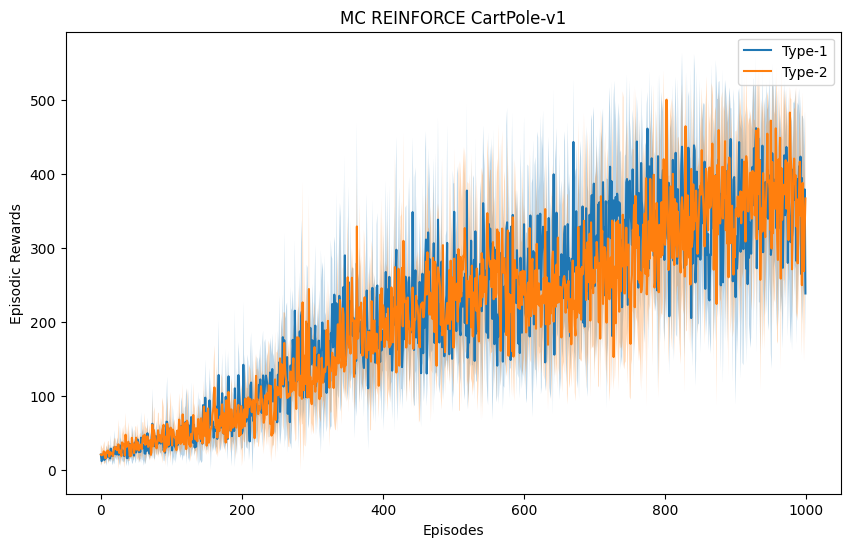

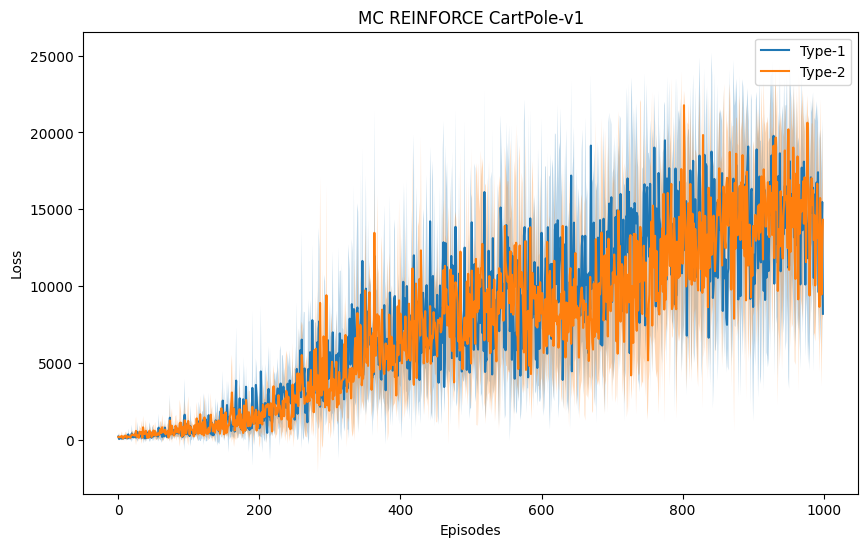

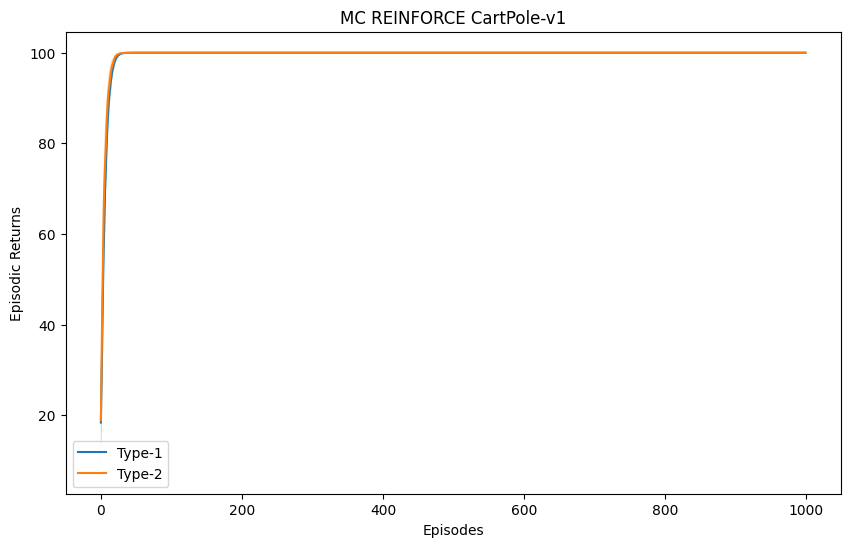

In [26]:
# Monte Carlo REINFORCE
# CartPole-v1 without baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=False, args=args)
rewards1, losses1, returns1 = trainer.train()

# CartPole-v1 with baseline
env_name = "CartPole-v1"
agent_type = "reinforce"
trainer = Trainer(env_name, agent_type, baseline=True, args=args)
rewards1, losses1, returns1 = trainer.train()

# Load results
rewards1, losses1, returns1 = results_loader("CartPole-v1", "reinforce", baseline=False)
rewards2, losses2, returns2 = results_loader("CartPole-v1", "reinforce", baseline=True)

# Plots
plot_rewards(rewards1, rewards2, "MC REINFORCE CartPole-v1", "plots/mc_reinforce_cartpole_rewards")
plot_losses(losses1, losses2, "MC REINFORCE CartPole-v1", "plots/mc_reinforce_cartpole_losses")
plot_returns(returns1, returns2, "MC REINFORCE CartPole-v1", "plots/mc_reinforce_cartpole_returns")
